> Abstract: Hago una funcion que me permita hacer combinaciones de listas y arrays. Encuentro un modelo, pero por la pandemia hay un outlier que hace que no se cumplan los supuestos. Entonces intento distintas formas de ajustar el modelo, con *aditive outlier* y *kalman filter*.

In [2]:
import pandas as pd
import numpy as np

In [3]:
from style import plotly_apply
plotly_apply()

In [4]:
def construccion_de_A(T: int) -> np.ndarray:
    """Construye la matriz A, que es una matriz de diferencias finitas de segundo orden."""
    A = np.zeros((T-2, T))      # Crea una matriz de ceros de tamaño (T-2) x T
    for i in range(T-2):        # Llena la matriz A con los coeficientes de diferencias finitas
        A[i, i:i+3] = 1, -2, 1
    return A    

# Hacerlo una funcion
def hodrick_prescott_filter(series: pd.Series, lamb: float) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Aplica el filtro de Hodrick-Prescott a una serie temporal.
    
    Args:
        series (pd.Series): Serie temporal a la que se le aplicará el filtro.
        lamb (float): Parámetro de suavizamiento del filtro.
        
    Returns:
        tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]: Una tupla que contiene la tendencia, el ciclo y la desviación porcentual.
    """
    index = series.index
    name = series.name
    series = np.asarray(series).flatten()

    N = len(series)
    A = construccion_de_A(N)

    tendencia = np.linalg.inv(np.identity(N) + lamb * (A.T @ A)) @ series
    ciclo = series - tendencia
    desviacion = 100 * (series / tendencia - 1)

    tendencia = pd.DataFrame(tendencia, index=index, columns=[name])
    ciclo = pd.DataFrame(ciclo, index=index, columns=[name])
    desviacion = pd.DataFrame(desviacion, index=index, columns=[name])

    return tendencia, ciclo, desviacion

In [5]:
gpd = pd.read_csv('GDP EEUU', index_col=0, parse_dates=True, names=['Fecha', 'GDP'], header=0)
tendencia, ciclo, desviacion = hodrick_prescott_filter(gpd['GDP'], lamb=1600)

In [6]:
gpd['GDP'].plot(title='Producto Interno Bruto Real de Estados Unidos (Billones de Dólares)')
tendencia.plot(title='Tendencia del Producto Interno Bruto Real de Estados Unidos (Billones de Dólares)')
ciclo.plot(title='Ciclo del Producto Interno Bruto Real de Estados Unidos (Billones de Dólares)')
#desviacion.plot(title='Desviación Porcentual del Producto Interno Bruto Real de Estados Unidos (%)')

**Poner la serie en escala logaritmica sirve de tres cosas clave:**

1. Modelo multiplicativo → aditivo.
   Si $Y_t=T_t\cdot C_t$ con ciclo proporcional al nivel, entonces
   $\log Y_t=\tau_t+c_t$. El HP trabaja mejor con $c_t$ de amplitud aproximadamente constante. Sin log, $Y_t=\tau_t+c_t$ impone ciclos de tamaño absoluto fijo, lo que suele ser falso en macro.

2. Estabilizar varianza y hacer ARMA plausible.
   $\operatorname{Var}(Y_t)$ suele crecer con el nivel. En log, $\operatorname{Var}(\log Y_t)$ es más estable. Los residuos del ciclo se acercan a homocedasticidad y a gaussianidad, lo que mejora ajuste y pronóstico ARMA del ciclo.

3. Interpretación económica directa.
   $\Delta \log Y_t \approx g_t$ es tasa de crecimiento. Pronosticar en log produce bandas y errores en porcentajes, que es lo que importa en práctica.

Detalles útiles:

* Requiere $Y_t>0$. Si hay ceros, use $\log(1+Y_t)$ o un shift positivo y documente la interpretación.
* Al volver a niveles, corrija el sesgo por Jensen si asume normalidad: si $\hat y\sim \mathcal N(\mu,\sigma^2)$, entonces $E[Y]\approx \exp(\mu+\tfrac12\sigma^2)$.
* El $\lambda$ del HP no cambia por escalar la serie, pero el log no es un simple reescalado: cambia la relación nivel–volatilidad y hace más lineal la tendencia.


In [7]:
y = np.log(gpd['GDP'])
tendencia, ciclo, desviacion = hodrick_prescott_filter(y, lamb=1600)

**Se hace ARMA en el ciclo porque ARMA exige estacionariedad y el ciclo sí la cumple; la tendencia HP no.**

* Descomposición: $y_t=\tau_t+c_t$, con $E[c_t]=0$, $c_t$ ≈ estacionario; $\tau_t$ es no estacionaria de baja frecuencia.
* Supuesto ARMA: procesos covarianza-estacionarios alrededor de media constante. Eso describe $c_t$, no $\tau_t$.
* El HP impone suavidad vía $\min_{\tau}\sum(y_t-\tau_t)^2+\lambda\sum(\Delta^2\tau_t)^2$. Esa dinámica equivale a un “trend” tipo I(2) local, no a ARMA.
* Poner ARMA sobre $\tau_t$ fuerza a diferenciarla. Modelar $\Delta\tau_t$ o $\Delta^2\tau_t$ destruye la separación tendencia–ciclo y te devuelve a un ARIMA sobre $y_t$.
* Identificación de frecuencias: ARMA sobre $\tau_t$ reintroduce componentes de media cero y “contamina” el ciclo.
* Borde temporal: la $\tau_t$ de HP es inestable en los extremos; ARMA no corrige eso. Un modelo estructural sí.
* Práctica estándar:

  * Ciclo: $c_t=\Phi(B)^{-1}\Theta(B)\varepsilon_t$ (ARMA).
  * Tendencia: local linear trend en espacio de estados
    $\tau_t=\tau_{t-1}+\beta_{t-1}+\eta_t,\quad \beta_t=\beta_{t-1}+\zeta_t$
    o RW con deriva.
* Pronóstico coherente: $\hat y_{T+h}=\hat\tau_{T+h|T}+\hat c_{T+h|T}$.
* Si insistes en “ARMA de tendencia”: ajusta ARMA a $\Delta^2\tau_t$ y luego integra dos veces. Es redundante frente a ARIMA/estructurales y pierde claridad.


# Pronóstico ARMA del ciclo HP

In [8]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import jarque_bera

In [10]:
ciclo = ciclo.asfreq('QS-JAN')  # evita warning

In [11]:
def get_all_combinations(p: int) -> list[tuple[int, ...]]:
    """Genera todas las combinaciones posibles de ceros y unos de longitud hasta p, 
    asegurando que cada combinación termine en 1, y que la combinación (0,) esté incluida.
    
    Args:
        p (int): La longitud máxima de las combinaciones.
        
    Returns:
        list[tuple[int, ...]]: Una lista de tuplas que representan las combinaciones.
    """
    all_combinations = []
    all_combinations.append((0,))  # Include the (0,) combination
    for i in range(1, p+1):
        for comb in product([0, 1], repeat=i):
            if comb[-1] == 1:  # Only include combinations ending with 1
                all_combinations.append(comb)
    return all_combinations

In [12]:
p_combs = get_all_combinations(3)
p_combs

[(0,), (1,), (0, 1), (1, 1), (0, 0, 1), (0, 1, 1), (1, 0, 1), (1, 1, 1)]

## Aditive Outlier (AO) en abril 2020

In [39]:
idx = ciclo.index

Pulse/dummy: una columna adicional que vale 1 solo en 2020‑04 y 0 en el resto. Su coeficiente captura el efecto puntual (Additive Outlier, AO).

In [38]:
ao_2020_04 = (idx == pd.Timestamp('2020-04-01')).astype(int)
ao_2020_04

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [40]:
# Opcionales: otras intervenciones
ls_from_2020_04 = (idx >= pd.Timestamp('2020-04-01')).astype(int)   # level shift
delta = 0.7  # tasa de decaimiento (0<delta<1) para TC
tc = np.zeros(len(y))
start = np.where(idx == pd.Timestamp('2020-04-01'))[0]
if len(start):
    s = start[0]
    tc[s:] = delta ** np.arange(0, len(y) - s)

exog = pd.DataFrame({
    'ao_2020_04': ao_2020_04,
    # 'ls_from_2020_04': ls_from_2020_04,  # si aplica
    # 'tc_2020_04': tc,                     # si aplica
}, index=idx)


## Fitting y selección de modelo

In [ ]:
def _roots_ok(m, margin=1.02):
    """Verifica que las raíces del modelo ARMA estén fuera del círculo unitario con un margen dado, el margen por defecto es 1.02, significa que las raíces deben estar al menos al 102% de la distancia del círculo unitario, una raíz en el círculo unitario tiene valor absoluto 1."""
    # raíces fuera del círculo unitario con margen
    ok_ar = (len(m.arroots)==0) or (np.min(np.abs(m.arroots)) > margin)
    ok_ma = (len(m.maroots)==0) or (np.min(np.abs(m.maroots)) > margin)
    return ok_ar and ok_ma

def _resid_tests(resid, lags=(12, 24), alpha=0.05):
    resid = pd.Series(resid).dropna()
    # Blanco: Ljung–Box en varios lags
    lb = acorr_ljungbox(resid, lags=max(lags), return_df=True)
    ok_lb = all(lb.loc[lag, 'lb_pvalue'] > alpha for lag in lags if lag <= len(lb))
    # ARCH: no heterocedasticidad condicional
    arch_stat, arch_p, _, _ = het_arch(resid, nlags=min(12, max(5, len(resid)//20)))
    ok_arch = arch_p > alpha
    # Normalidad: Jarque–Bera (criterio suave)
    jb_stat, jb_p, skew, kurt = jarque_bera(resid)
    return {
        'ok_lb': ok_lb, 'ok_arch': ok_arch, 'ok_jb': jb_p > alpha,
        'jb_p': jb_p, 'arch_p': arch_p,
        'lb_p@{}': float(lb.iloc[min(max(lags), len(lb))-1]['lb_pvalue'])
    }

def seleccionar_arma_ciclo(serie, max_p=3, max_q=3, alpha=0.05):
    """
    serie: ciclo HP (media ~0), Index temporal regular.
    Devuelve el mejor modelo que CUMPLE supuestos. Fallback: mejor AIC con motivos.
    """
    y = pd.Series(serie).dropna()
    if y.index.freq is None:
        y = y.asfreq(pd.infer_freq(y.index))

    candidatos = []
    fallback = None
    p_combs = get_all_combinations(max_p)
    q_combs = get_all_combinations(max_q)

    for p, q in product(p_combs, q_combs):        # se usa product para generar pares (p,q)
        try:
            # Tendencia nula en ciclo; forzar restricciones
            mod = ARIMA(y, order=(p, 0, q), trend='n',
                        enforce_stationarity=True, enforce_invertibility=True, 
                        exog=exog)
            res = mod.fit()
            # guardar fallback por AIC
            if fallback is None or res.aic < fallback[0]:
                fallback = (res.aic, (p, q), res, None)

            # raíces con margen
            if not _roots_ok(res):
                continue

            # diagnósticos de residuos
            tests = _resid_tests(res.resid, lags=(12, 24), alpha=alpha)
            # criterio: blanco y sin ARCH; normalidad opcional pero preferida
            if tests['ok_lb'] and tests['ok_arch']:
                # penaliza si no normal, pero acepta
                score = res.aic + (0 if tests['ok_jb'] else 2.0)
                candidatos.append((score, (p, q), res, tests))
        except Exception:
            continue

    if candidatos:
        candidatos.sort(key=lambda z: z[0])
        return {'order': candidatos[0][1], 'result': candidatos[0][2], 'tests': candidatos[0][3], 'fallback_used': False}
    else:
        return {'order': fallback[1], 'result': fallback[2], 'tests': fallback[3], 'fallback_used': True}


In [44]:
sel = seleccionar_arma_ciclo(y, max_p=3, max_q=3, alpha=0.1)

c:\Users\herie\miniconda3\envs\u\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\herie\miniconda3\envs\u\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\herie\miniconda3\envs\u\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\herie\miniconda3\envs\u\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\herie\miniconda3\envs\u\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\herie\miniconda3\envs\u\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:


In [45]:
sel

{'order': ((1, 0, 1), (0,)),
 'result': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x2020e030f10>,
 'tests': None,
 'fallback_used': True}

In [46]:
best_model = sel['result']
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:                     GDP   No. Observations:                  314
Model:             ARIMA([1, 3], 0, 0)   Log Likelihood                1019.552
Date:                 Mon, 08 Sep 2025   AIC                          -2031.104
Time:                         20:19:40   BIC                          -2016.106
Sample:                     01-01-1947   HQIC                         -2025.111
                          - 04-01-2025                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ao_2020_04    -0.0804      0.016     -5.152      0.000      -0.111      -0.050
ar.L1          1.4201      0.026     54.629      0.000       1.369       1.471
ar.L3         -0.4201      0.026    -16.158      0.000      -0.471      -0.369
sigma2       8.54e-05   5.01e-06     17.035      0.000    7.56e-05    9.52e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                55.41
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Resumen: mejoró mucho con la exógena, pero aún no cumple todos los supuestos.

Estacionariedad: no. Los AR son L1=1.4201 y L3=−0.4201; su suma ≈ 1 → la ecuación AR tiene raíz unitaria (φ(1)=0). Con d=0 eso viola estacionariedad.
Autocorrelación: L‑Box a 1 rezago es ok (p=0.54), pero falta verificar en 10–20 rezagos para concluir.
Normalidad: no. JB p=0.00; skew=0.36, kurtosis=4.93 → colas pesadas (aunque muchísimo mejor que antes).
Homocedasticidad: no. H=0.29 con p=0.00 rechaza homocedasticidad.
Qué haría a continuación

Forzar estacionariedad: o bien diferencia (d=1) si modelas el nivel; si modelas el ciclo (que debe ser I(0)), re‑estima con enforce_stationarity=True y revisa que todas las raíces AR estén fuera del círculo unitario (res.arroots con módulo>1).
Confirmar residuos: Ljung–Box a 10 y 20 rezagos sobre residuos estandarizados (sm.stats.acorr_ljungbox(resid, lags=[10,20])).
Inferencia robusta: usa covarianzas robustas a no normalidad/hetero (fit(cov_type='robust')) para p‑valores/IC más confiables.
Volatilidad: si persiste heterocedasticidad, modela varianza (p. ej., GARCH sobre residuos del ARIMA) o usa errores robustos sistemáticamente.
Mantén la exógena AO 2020‑04: es significativa (z=−5.15) y captura bien el choque.
Si quieres, te paso el bloque exacto para: (a) checar raíces AR/MA y Ljung‑Box a 10/20, y (b) re‑estimar forzando estacionariedad y con cov_type='robust', para comparar diagnósticos.

In [55]:
# Ljung-Box
acorr_ljungbox(best_model.resid, lags=24, return_df=True)

,lb_stat,lb_pvalue
1,0.000080,0.992851
2,0.000105,0.999947
3,0.001423,0.999986
4,0.001709,1.000000
5,0.001721,1.000000
6,0.002166,1.000000
7,0.002716,1.000000
8,0.004653,1.000000
9,0.004653,1.000000
10,0.006064,1.000000


In [58]:
het_arch(best_model.resid, maxlag=12)

C:\Users\herie\AppData\Local\Temp\ipykernel_37728\290251479.py:1: FutureWarning:

the 'maxlag' keyword is deprecated, use 'nlags' instead.



(np.float64(94.71893219899319),
 np.float64(5.9869361557959166e-15),
 11.005093911015988,
 4.5927916317755174e-18)

Conclusión: hay heterocedasticidad condicional clara.

Evidencia: het_arch devuelve LM=94.72 (p≈6e-15) y F=11.01 (p≈5e-18) → rechaza homocedasticidad. Hay varianza dinámica (volatilidad) en los residuos.
Implicación: los errores típicos e IC “clásicos” del ARIMA no son fiables; los pronósticos puntuales pueden estar bien, pero los intervalos serán optimistas si no ajustas la varianza.
Opciones prácticas

Robustecer inferencia: re‑estima con covarianza robusta.
res = mod.fit(cov_type='robust') // en SARIMAX
Úsalo para p‑valores/IC del modelo actual; mantiene tu media y la dummy AO 2020‑04.
Modelar la varianza: ARX/SARIMA + GARCH.
Con arch:
from arch.univariate import ARX, GARCH, StudentsT
am = ARX(y, lags=[1,3], x=exog[['ao_2020_04']])
am.volatility = GARCH(1,1); am.distribution = StudentsT() // colas pesadas
res_g = am.fit(disp='off')
Luego valida de nuevo het_arch sobre los residuos estandarizados; deberían perder efecto ARCH.
Capturar el brote de varianza 2020: si la volatilidad solo sube alrededor de 2020‑04, prueba EGARCH/GJR (permite asimetrías) o incluye dummies de varianza (p. ej., entrenar GARCH con un “regressor” de varianza alrededor de 2020). En práctica, GARCH(1,1) + t suele bastar.
Recomendación

Si te importa principalmente inferencia/IC: usa cov_type='robust' y listo.
Si te importan IC de pronóstico creíbles y la dinámica de volatilidad: ajusta ARX‑GARCH con StudentsT y compara AIC/BIC y diagnósticos (Ljung–Box, JB, het_arch).

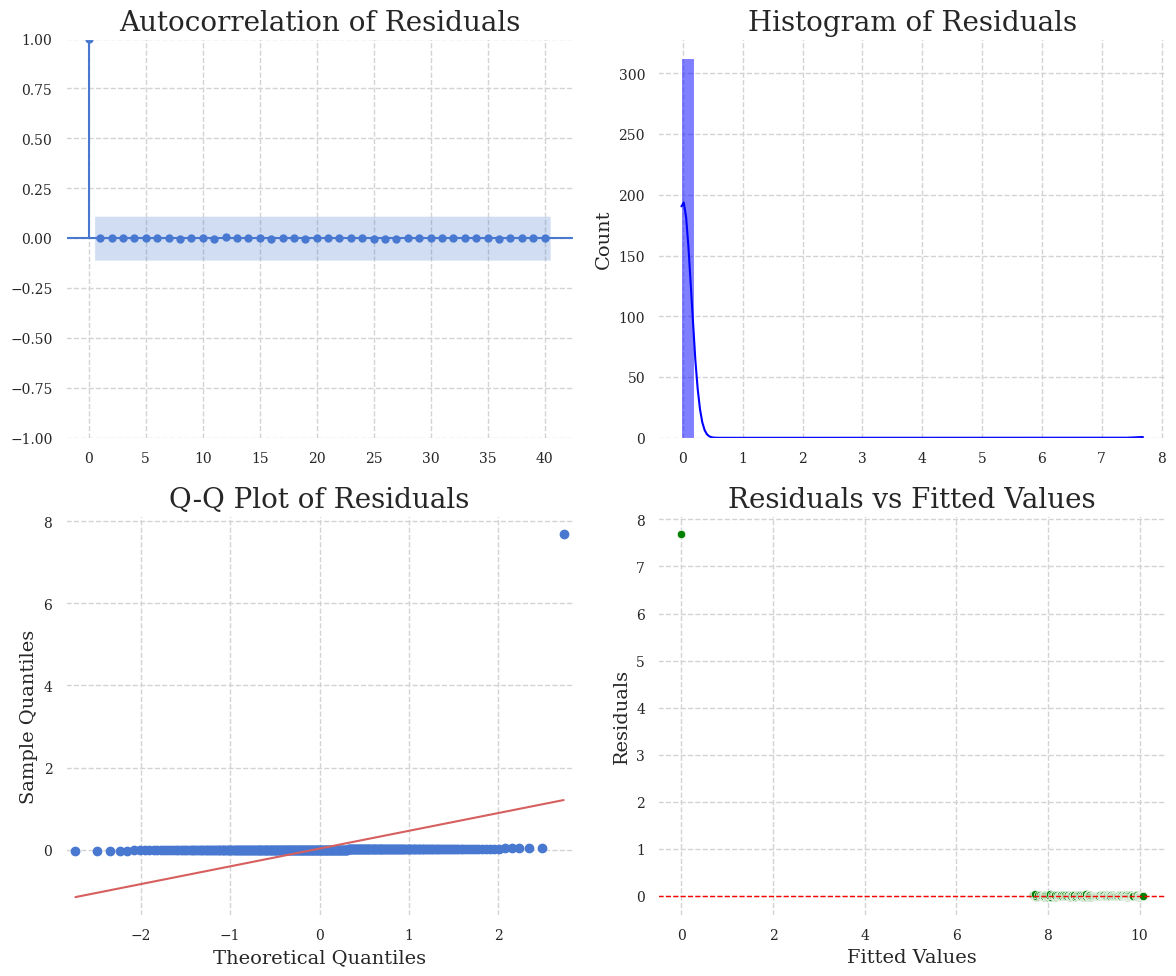

In [52]:
import seaborn as sns

from style import mpl_apply
mpl_apply()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Autocorrelation plot
sm.graphics.tsa.plot_acf(best_model.resid.dropna(), lags=40, ax=axes[0, 0])
axes[0, 0].set_title('Autocorrelation of Residuals')

# Histogram with KDE
sns.histplot(best_model.resid.dropna(), kde=True, ax=axes[0, 1], color='blue')
axes[0, 1].set_title('Histogram of Residuals')

# Q-Q Plot
sm.qqplot(best_model.resid.dropna(), line='s', ax=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot of Residuals')

# Residuals vs Fitted Values
sns.scatterplot(x=best_model.fittedvalues, y=best_model.resid, ax=axes[1, 1], color='green')
axes[1, 1].axhline(0, linestyle='--', color='red', linewidth=1)
axes[1, 1].set_title('Residuals vs Fitted Values')
axes[1, 1].set_xlabel('Fitted Values')
axes[1, 1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

In [66]:
# ARX–GARCH con AO 2020-04 y diagnósticos (corregido)
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from arch.univariate import ARX, GARCH, StudentsT

y = ciclo
idx = y.index

# Dummy AO para abril-2020 robusta a M/Q y a fin-de-mes
ao = pd.Series(0, index=y.index, dtype=int)
if isinstance(idx, pd.PeriodIndex):
    f = str(idx.freq).upper()
    if f.startswith('Q'):
        ao.loc[idx == pd.Period('2020Q2', freq=idx.freq)] = 1
    elif f.startswith('M'):
        ao.loc[idx == pd.Period('2020-04', freq=idx.freq)] = 1
else:
    # DateTimeIndex
    if pd.infer_freq(idx) and 'Q' in pd.infer_freq(idx).upper():
        ao.loc[idx.to_period('Q') == pd.Period('2020Q2')] = 1
    else:
        ao.loc[idx.to_period('M') == pd.Period('2020-04')] = 1

X = ao.to_frame('ao_2020_04').astype(float)

am = ARX(y, lags=[1, 3], constant=False, x=X)
am.volatility = GARCH(1, 1)
am.distribution = StudentsT()

res_g = am.fit(disp='off')
res_g.summary()

c:\Users\herie\miniconda3\envs\u\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.087e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR-X - GJR-GARCH Model Results                           
====================================================================================
Dep. Variable:                          GDP   R-squared:                       0.723
Mean Model:                            AR-X   Adj. R-squared:                  0.721
Vol Model:                        GJR-GARCH   Log-Likelihood:                1100.17
Distribution:      Standardized Student's t   AIC:                          -2184.35
Method:                  Maximum Likelihood   BIC:                          -2154.43
                                              No. Observations:                  311
Date:                      Mon, Sep 08 2025   Df Residuals:                      308
Time:                              20:32:08   Df Model:                            3
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
GDP[1]         0.9851  5.014e-02     19.646  6.314e-86       [  0.887,  1.083]
GDP[3]        -0.2036  4.537e-02     -4.488  7.195e-06       [ -0.293, -0.115]
ao_2020_04    -0.0851  1.303e-03    -65.272      0.000 [-8.762e-02,-8.251e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      7.8169e-06  4.168e-08    187.560      0.000 [7.735e-06,7.899e-06]
alpha[1]       0.1003      0.282      0.356      0.722     [ -0.452,  0.653]
gamma[1]       0.1989      0.399      0.498      0.618     [ -0.584,  0.981]
beta[1]        0.6981      0.144      4.850  1.236e-06     [  0.416,  0.980]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.8945      2.321      2.109  3.498e-02 [  0.345,  9.444]
========================================================================

Covariance estimator: robust
"""

In [ ]:
# Diagnósticos sobre residuos estandarizados
std_resid = res_g.resid / res_g.conditional_volatility
std_resid = std_resid.replace([np.inf, -np.inf], np.nan).dropna()
lb = acorr_ljungbox(std_resid, lags=[10, 20, 24], return_df=True)
jb_stat, jb_pvalue, skew, kurt = sm.stats.jarque_bera(std_resid)
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(std_resid, maxlag=12)

C:\Users\herie\AppData\Local\Temp\ipykernel_37728\2647855826.py:6: FutureWarning:

the 'maxlag' keyword is deprecated, use 'nlags' instead.



In [ ]:
print("\nLjung-Box (std resid) p-values:\n", lb['lb_pvalue'])
print(f"\nJarque-Bera: stat={jb_stat:.3f}, p={jb_pvalue:.3g}, skew={skew:.2f}, kurt={kurt:.2f}")
print(f"ARCH-LM(12): LM={lm_stat:.2f}, p={lm_pvalue:.3g}; F={f_stat:.2f}, p={f_pvalue:.3g}")


Ljung-Box (std resid) p-values:
 10    0.657692
20    0.474873
24    0.426221
Name: lb_pvalue, dtype: float64

Jarque-Bera: stat=1267.896, p=4.79e-276, skew=1.01, kurt=12.68
ARCH-LM(12): LM=4.19, p=0.98; F=0.34, p=0.981


Sí: para los objetivos de media y varianza, el modelo quedó bien.

Autocorrelación: Ljung–Box en 10/20/24 rezagos con p>0.4 → residuos blancos.
Heterocedasticidad: ARCH‑LM(12) p≈0.98 → la GARCH(1,1) eliminó el efecto ARCH.
Normalidad: JB rechaza con fuerza (skew=1.01, kurt=12.68). No es un “fallo” aquí porque estás estimando con t‑Student; JB contrasta contra normal, no contra t. La inferencia/IC ya están ajustados a colas pesadas.
Qué afinar (opcional)

Asimetría: el sesgo positivo sugiere probar distribución sesgada o volatilidad con apalancamiento:
Distribución: SkewStudent() o GED() y comparar AIC/BIC.
Volatilidad: EGARCH(1,1) o GJR(1,1) si persiste asimetría en shocks.
Grado de colas: revisa res_g.params['nu'] (t‑Student). Nu bajo (<10) confirma colas pesadas coherentes con JB.

In [74]:
from arch.univariate import StudentsT, SkewStudent

for dist in [StudentsT(), SkewStudent()]:
    am = ARX(y, lags=[1,3], constant=False, x=X)
    am.volatility = GARCH(1,1)
    am.distribution = dist
    res = am.fit(disp='off')
    print(dist.__class__.__name__, 'AIC:', res.aic)

StudentsT AIC: -2184.3488141449925
SkewStudent AIC: -2182.5067234249236


c:\Users\herie\miniconda3\envs\u\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.087e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


c:\Users\herie\miniconda3\envs\u\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.087e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




In [ ]:
def pronosticar_ciclo(res, h=12, alpha=0.2):
    fc = res.get_forecast(h)
    mean = fc.predicted_mean
    ci = fc.conf_int(alpha=alpha)
    return mean, ci

In [60]:
def plot_ciclo_con_pronostico(ciclo, res, h=12, alpha=0.2, titulo='Ciclo HP + ARMA'):
    mean, ci = pronosticar_ciclo(res, h=h, alpha=alpha)
    idx_hist = ciclo.index
    idx_fc = mean.index

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.axhline(0.0, linewidth=0.8)
    ax.plot(idx_hist, ciclo, label='Ciclo HP')
    ax.plot(idx_fc, mean, label='Pronóstico ciclo', linewidth=1.8)
    ax.fill_between(idx_fc, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.2, step='pre', label=f'Banda {int((1-alpha)*100)}%')
    ax.set_title(titulo)
    ax.legend()
    plt.tight_layout()
    return fig


In [61]:
fig = plot_ciclo_con_pronostico(ciclo, sel['result'], h=12, alpha=0.2, titulo='Ciclo y pronóstico')
plt.show()

ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.

In [ ]:



# === Uso típico ===
# y_ciclo = ciclo['GDP']  # tu serie del componente cíclico
# sel = seleccionar_arma_ciclo(y_ciclo, max_p=3, max_q=3, alpha=0.05)
# print("Orden seleccionado:", sel['order'], "fallback:", sel['fallback_used'])
# if sel['tests'] is not None:
#     print(sel['tests'])

